In [2]:
from ast import literal_eval
import numpy as np
from atmos_cloud_sim_uj_utils import show_plot
from matplotlib import pyplot
from joblib import Parallel, delayed, parallel_backend

In [4]:
import os
os.environ["NUMBA_NUM_THREADS"] = "1"

In [5]:
from PySDM.physics import si
from PySDM.initialisation import discretise_multiplicities, equilibrate_wet_radii
from PySDM.initialisation.spectra import Lognormal
from PySDM.initialisation.sampling import spectral_sampling
from PySDM.backends import CPU
from PySDM.dynamics import AmbientThermodynamics, Condensation
from PySDM.environments import Parcel
from PySDM import Builder, Formulae, products

In [6]:
def run(**args):
    env = Parcel(
      dt=.25 * si.s,
      mass_of_dry_air=1e3 * si.kg,
      p0=args['p0'],
      q0=20 * si.g / si.kg,
      T0=args['T0'],
      w=2.5 * si.m / si.s
    )
    spectrum = Lognormal(norm_factor=1e4 / si.mg, m_mode=50 * si.nm, s_geom=1.5)
    kappa = .5 * si.dimensionless
    cloud_range = (.5 * si.um, 25 * si.um)
    output_interval = 4
    output_points = 40
    n_sd = 256

    formulae = Formulae()
    builder = Builder(backend=CPU(formulae), n_sd=n_sd)
    builder.set_environment(env)
    builder.add_dynamic(AmbientThermodynamics())
    builder.add_dynamic(Condensation())

    r_dry, specific_concentration = spectral_sampling.Logarithmic(spectrum).sample(n_sd)
    v_dry = formulae.trivia.volume(radius=r_dry)
    r_wet = equilibrate_wet_radii(r_dry, env, kappa * v_dry)

    attributes = {
      'n': discretise_multiplicities(specific_concentration * env.mass_of_dry_air),
      'dry volume': v_dry,
      'kappa times dry volume': kappa * v_dry,
      'volume': formulae.trivia.volume(radius=r_wet)
    }

    particulator = builder.build(attributes, products=[
      products.PeakSupersaturation(name='S_max', unit='%'),
      products.EffectiveRadius(name='r_eff', unit='um', radius_range=cloud_range),
      products.ParticleConcentration(name='n_c_cm3', unit='cm^-3', radius_range=cloud_range),
      products.WaterMixingRatio(name='ql', unit='g/kg', radius_range=cloud_range),
      products.ParcelDisplacement(name='z')
    ])

    cell_id = 0
    output = {product.name: [product.get()[cell_id]] for product in particulator.products.values()}

    for step in range(output_points):
      particulator.run(steps=output_interval)
      for product in particulator.products.values():
        output[product.name].append(product.get()[cell_id])
    return (str(args), output)

In [10]:
# with parallel_backend('threading', n_jobs=-2):
with parallel_backend("loky", n_jobs=-2):
    data = Parallel(verbose=10)(
        delayed(run)(**{'p0': p0, 'T0': T0})
            for p0 in (1122 * si.hPa, 1133 * si.hPa)
            for T0 in (300 * si.K, 303 * si.K)
    )
data = dict(data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done   2 out of   4 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:  2.0min finished


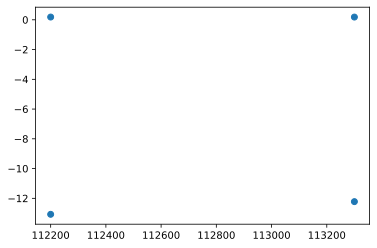

HTML(value="<a href='.\\fig_1.pdf' target='_blank'>.\\fig_1.pdf</a><br>")

In [11]:
pyplot.scatter(
    [literal_eval(key)['p0'] for key in data.keys()],
    [np.nanmax(val['S_max']) for val in data.values()]
)
show_plot("fig_1.pdf")